# **Ship Vs IceBerg**

### The Statoil Iceberg Classifier Challenge is a dataset available on Kaggle that provides a unique opportunity to apply deep learning techniques to a real-world problem. The dataset includes images of ships and icebergs, taken from a satellite, and the goal is to classify these images as either a ship or an iceberg. This dataset is particularly interesting because it presents a challenging problem due to the similarity in appearance between ships and icebergs. The data set is composed of 2,801 images with different sizes and angles, which makes it a great dataset to work with deep learning models, especially those that are able to deal with image classification problems. The dataset provides a great opportunity to work with a real-world problem and test the performance of different deep learning models.

In [356]:
# let's import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path
import tensorflow as tf
import random
from sklearn.metrics import confusion_matrix
import itertools


In [357]:
print(tf.__version__)

2.9.1


In [770]:
data = pd.read_json("/home/pouria/train.json")
data.head(10)

,id,band_1,band_2,inc_angle,is_iceberg
0,dfd5f913,"[-27.878360999999998, -27.15416, -28.668615, -...","[-27.154118, -29.537888, -31.0306, -32.190483,...",43.9239,0
1,e25388fd,"[-12.242375, -14.920304999999999, -14.920363, ...","[-31.506321, -27.984554, -26.645678, -23.76760...",38.1562,0
2,58b2aaa0,"[-24.603676, -24.603714, -24.871029, -23.15277...","[-24.870956, -24.092632, -20.653963, -19.41104...",45.2859,1
3,4cfc3a18,"[-22.454607, -23.082819, -23.998013, -23.99805...","[-27.889421, -27.519794, -27.165262, -29.10350...",43.8306,0
4,271f93f4,"[-26.006956, -23.164886, -23.164886, -26.89116...","[-27.206915, -30.259186, -30.259186, -23.16495...",35.6256,0
5,b51d18b5,"[-20.769371, -20.769434, -25.906025, -25.90602...","[-29.288746, -29.712593, -28.884804, -28.88480...",36.9034,1
6,31da1a04,"[-26.673811, -23.666162, -27.622442, -28.31768...","[-24.557735, -26.97868, -27.622442, -29.073456...",34.4751,1
7,56929c16,"[-24.989119, -27.755224, -25.817074, -24.98927...","[-27.755173, -26.732174, -28.124943, -31.83772...",41.1769,0
8,525ab75c,"[-17.146641, -17.146572, -17.994583, -19.44553...","[-25.733608, -24.472507, -24.710424, -22.77215...",35.7829,0
9,192f56eb,"[-24.020853, -23.551275, -27.18819, -29.126434...","[-28.702518, -33.563324, -29.571918, -29.12643...",43.3007,0


In [359]:
# data information
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1604 entries, 0 to 1603
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          1604 non-null   object
 1   band_1      1604 non-null   object
 2   band_2      1604 non-null   object
 3   inc_angle   1604 non-null   object
 4   is_iceberg  1604 non-null   int64 
dtypes: int64(1), object(4)
memory usage: 62.8+ KB


In [360]:
#studying whether data lables are balance or not.
data['is_iceberg'].value_counts()

0    851
1    753
Name: is_iceberg, dtype: int64

### let's becoming one with the data.

- ID is the ID of each satellite image.
- "band1" and "band2" refer to two different types of images of the same area captured by a satellite
- inc_angle, Incidence angle, is the angle between the satellite and the iceberg or ship.
- see https://www.degruyter.com/document/doi/10.1515/geo-2016-0029/html?lang=en fro more information.
- is_iceberg is whether the satellite image is iceberg or ship.
- there are 1604 data points for each column without any missing data.
- the portion of the data is roughly equal to 55% to 45%. So, the data is balanced.

### let's start data visualization.

In [361]:
len(data.iloc[1][1]), len(data.iloc[1][2])
# it is the lengh of the each band.

(5625, 5625)

In [771]:
# we need to reshape the data to 75 by 75 pixels.
X_band_1 = np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in data["band_1"]])
X_band_2 = np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in data["band_2"]])

### There are 1604 images with size of 75 by 75 in each band. 

In [363]:
print(X_band_1.shape)
print(X_band_2.shape)

(1604, 75, 75)
(1604, 75, 75)


In [772]:
# let's define the index for ship and iceberg
ship_index = np.where(data['is_iceberg']==0)
ice_index = np.where(data['is_iceberg']==1)

### Define a function to visualize our dataset.

In [366]:
# def a function to plot the image for ships and icebergs.
# this function select a band from the band_1 and band_2 then plot based on the index.
def plots(band,index,title):
    plt.figure(figsize=(12,10))
    for i in range(6):
        plt.subplot(2,3,i+1)
        plt.xticks(())
        plt.yticks(())
        plt.xlabel((title))
        plt.imshow(np.reshape(data[band][index[0][i]], (75,75)),cmap='rainbow')
    plt.show()  

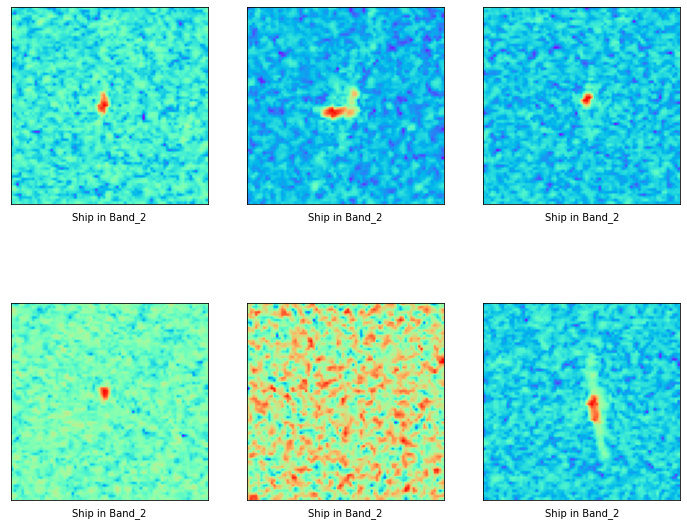

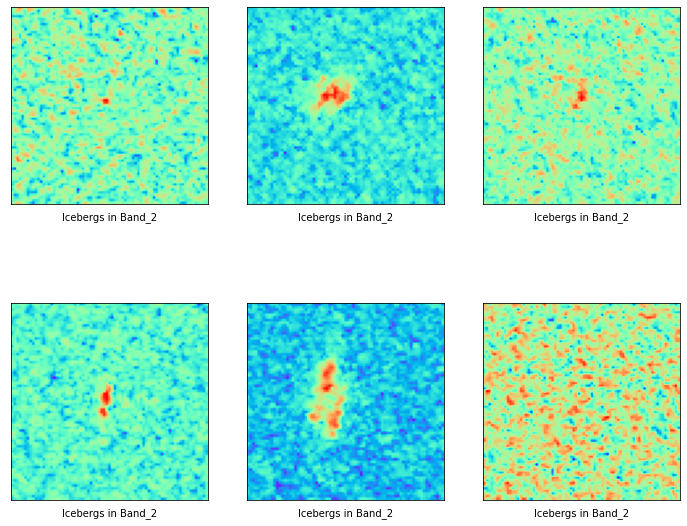

In [367]:
plots('band_2',ship_index,'Ship in Band_2'), plots('band_2', ice_index,'Icebergs in Band_2');
# it is a simple data visualization for ships and Icebergs in Band_2.

# Deep Learng and Machine Learning 

### Initially, we will begin with basic models by removing the inc_angle variable and using only one band for prediction of iceberg or ship. Next, we will evaluate the impact of normalization on the data. After that, we will normalize the data based on the inc_angle variable and apply deep learning techniques. Lastly, we will merge both bands to create a new feature for training, which will incorporate information from both bands.


### Define a function to plot Accuacy and Loss

In [773]:
def plot_loss_curves(history):

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();


### Create a function to preserve the model with **the Maximum validation accuracy**.

In [774]:
# Create a function to implement a ModelCheckpoint callback with a specific filename 
def create_model_checkpoint(model_name, save_path="model_experiments"):
  return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name), # create filepath to save model
                                            monitor='val_accuracy',
                                            verbose=0, # only output a limited amount of text
                                            save_best_only=True)

### Define a function to plot the confusion matrix 

In [775]:
def plot_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False): 
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])
  
  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")

# Use Band1 as the feature

In [776]:
X = X_band_1
y = data['is_iceberg']

In [777]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
tf.random.set_seed(42) # random seed for Reproducibility
# Conv2D model 
model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, (2,2), activation='relu', input_shape=(75, 75,1)),
        tf.keras.layers.MaxPool2D(2,2),
        tf.keras.layers.Conv2D(64,  (2,2), activation='relu'),
        tf.keras.layers.MaxPool2D(2,2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid') # sigmoid activation as the labels are binary
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-5 * 10**(epoch/20)) # learning rate scheduler callback

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 1e-5),
              loss='binary_crossentropy', # binary_crossentropy as the labels are binary
              metrics=['accuracy'])


history = model.fit(X_train, y_train, epochs=100, verbose= 0,
            validation_data = (X_test,y_test), callbacks=[lr_schedule])

### Plot the learning rate Vs the accuracy to find the best learning rate for our model.

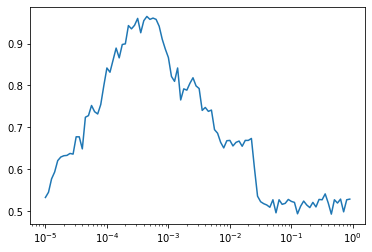

In [ ]:
plt.semilogx(history.history['lr'], history.history['accuracy'])

### As it appears, the optimal learning rate is around 0.001, which is higher than the default value of 0.0001. The use of a learning rate scheduler callback is crucial in determining this.

In [ ]:
tf.random.set_seed(42) # random seed for Reproducibility
# Conv2D model 
model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, (2,2), activation='relu', input_shape=(75, 75,1)),
        tf.keras.layers.MaxPool2D(2,2),
        tf.keras.layers.Conv2D(64,  (2,2), activation='relu'),
        tf.keras.layers.MaxPool2D(2,2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid') # sigmoid activation as the labels are binary
], name = 'model_conv2d_band1')

early_stopping = tf.keras.callbacks.EarlyStopping(patience = 10) # early stopping callback to stop the model for avoiding overfitting.


model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 1e-3),
              loss='binary_crossentropy', # binary_crossentropy as the labels are binary
              metrics=['accuracy'])


history = model.fit(X_train, y_train, epochs=300, verbose= 0,
            validation_data = (X_test,y_test), callbacks=[create_model_checkpoint(model_name=model.name),early_stopping])

In [779]:
model = tf.keras.models.load_model("model_experiments/model_conv2d_band1")
model_loss, model_accuracy = model.evaluate(X_test, y_test)
print(model_loss)
print(model_accuracy)

11/11 [==============================] - 0s 17ms/step - loss: 0.5986 - accuracy: 0.8006
0.5985809564590454
0.8006230592727661


In [780]:
band_1_df = pd.DataFrame(history.history)

### let's plot loss and accuracy

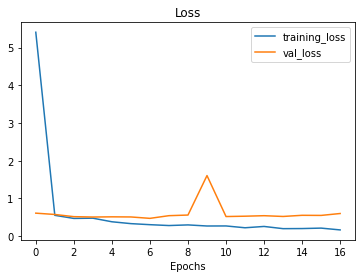

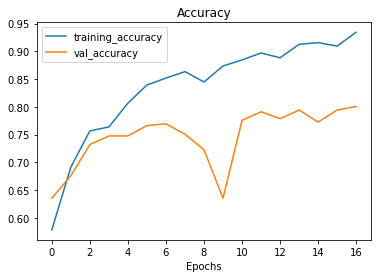

In [781]:
plot_loss_curves(history=history)

### Let's make prediction on test data and generate confusion matrix

In [782]:
y_pred = model.predict(X_test)
y_pred[:5] #see first 5 predictions

11/11 [==============================] - 0s 19ms/step


array([[9.9271959e-01],
       [5.9131366e-01],
       [5.8618467e-03],
       [5.8098018e-01],
       [6.8088087e-07]], dtype=float32)

### The outcome of the prediction is not binary, it is necessary to round the results. A function should be created to perform this task.

In [783]:
def prediction_function(X_test, pred): 
    prediction = []
    for i in range(len(X_test)):
        pred = np.round(y_pred[i])
        prediction.append(pred)
    return prediction

In [784]:
y_pred = prediction_function(X_test, y_pred)# it looks binary

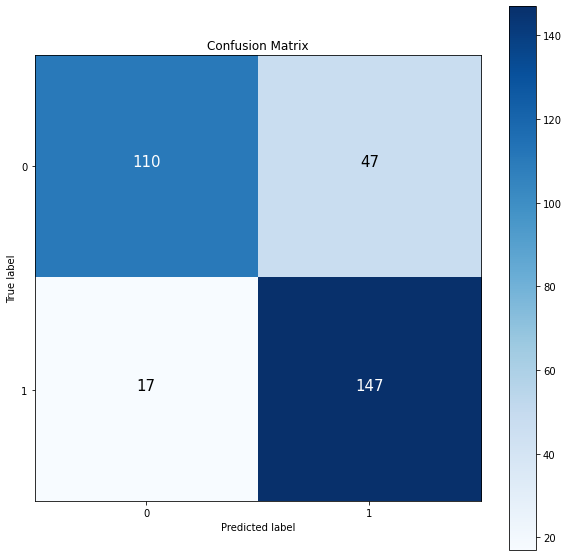

In [785]:
plot_confusion_matrix(y_test, y_pred)

### In the confusion matrix, out of 157 ships, 110 were correctly identified, and 47 were incorrectly classified as icebergs. Additionally, out of 164 icebergs, 147 were correctly identified, and 17 were incorrectly classified as ships.

# Let's do the same modeling for band 2 and compare the results

In [786]:
X = X_band_2
y = data['is_iceberg']
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
tf.random.set_seed(42) # random seed for Reproducibility
# Conv2D model 
model_2 = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, (2,2), activation='relu', input_shape=(75, 75,1)),
        tf.keras.layers.MaxPool2D(2,2),
        tf.keras.layers.Conv2D(64,  (2,2), activation='relu'),
        tf.keras.layers.MaxPool2D(2,2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid') # sigmoid activation as the labels are binary
], name = 'model_conv2d_band2')

early_stopping = tf.keras.callbacks.EarlyStopping(patience = 10) # early stopping callback to stop the model for avoiding overfitting.


model_2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 1e-3),
              loss='binary_crossentropy', # binary_crossentropy as the labels are binary
              metrics=['accuracy'])


history_2 = model_2.fit(X_train, y_train, epochs=300, verbose= 0,
            validation_data = (X_test,y_test), callbacks=[create_model_checkpoint(model_name=model_2.name), early_stopping])

# Let's repeat the previous steps, starting with evaluating the model, and ending with creating a confusion matrix.

In [788]:
model_2 = tf.keras.models.load_model("model_experiments/model_conv2d_band2")
model_2.evaluate(X_test, y_test)
model_2_loss, model_2_accuracy = model_2.evaluate(X_test, y_test)
print(model_2_loss)
print(model_2_accuracy)

11/11 [==============================] - 0s 20ms/step - loss: 0.4985 - accuracy: 0.7664
0.49845200777053833
0.7663551568984985


In [789]:
band_2_df = pd.DataFrame(history_2.history)

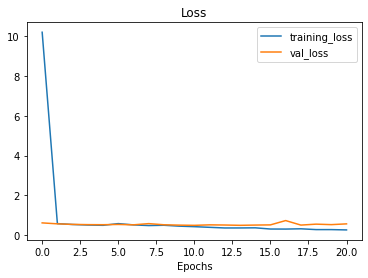

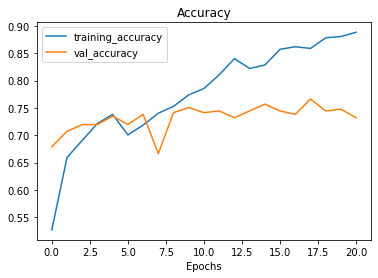

In [790]:
plot_loss_curves(history=history_2)

In [791]:
y_pred = model_2.predict(X_test)

11/11 [==============================] - 0s 17ms/step


In [792]:
y_pred=prediction_function(X_test, y_pred)

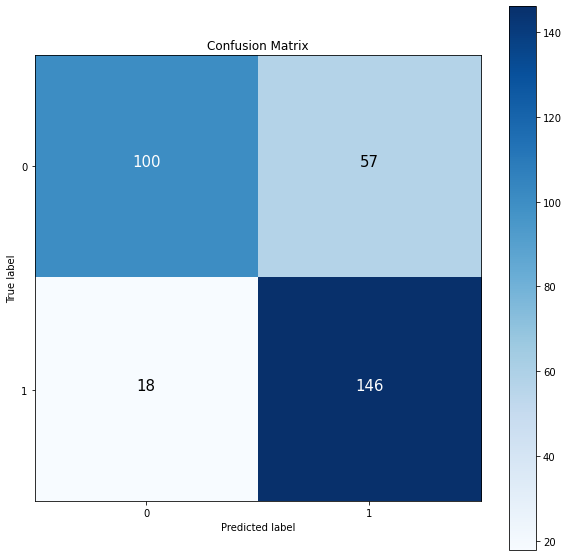

In [793]:
plot_confusion_matrix(y_test, y_pred)

### As evident, the Band_1 model performed better than the Band_2 model. The results of the confusion matrix for Band_2 indicate that out of 157 ships, 100 were correctly identified, and 57 were incorrectly classified as icebergs. Furthermore, out of 164 icebergs, 146 were correctly identified and 18 were incorrectly classified as ships.

# Conclusion
### **In conclusion, the Conv2D model that uses Band1 as a feature outperforms the model that uses Band2 as a feature.**.

# Scale the data

### In order to further improve the performance of the model, it is necessary to scale the Band_1 and Band_2 datasets. This is achieved by dividing each band by 255, as the maximum value for each pixel is 255. The rationale behind this is to ensure that all pixel values fall within the range of 0 to 1, which is a common normalization technique in deep learning. The scaled datasets will then be used in conjunction with the previously established Learning Rate and the Conv2D model to evaluate the impact of scaling on model performance.

In [794]:
X = X_band_1/255
y = data['is_iceberg']
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
tf.random.set_seed(42) # random seed for Reproducibility
# Conv2D model 
model_3 = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, (2,2), activation='relu', input_shape=(75, 75,1)),
        tf.keras.layers.MaxPool2D(2,2),
        tf.keras.layers.Conv2D(64,  (2,2), activation='relu'),
        tf.keras.layers.MaxPool2D(2,2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid') # sigmoid activation as the labels are binary
], name = 'model_conv2d_scaled_band1')

early_stopping = tf.keras.callbacks.EarlyStopping(patience = 10) # early stopping callback to stop the model for avoiding overfitting.


model_3.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 1e-3),
              loss='binary_crossentropy', # binary_crossentropy as the labels are binary
              metrics=['accuracy'])


history_3 = model_3.fit(X_train, y_train, epochs=300, verbose= 0,
            validation_data = (X_test,y_test), callbacks=[create_model_checkpoint(model_name=model_3.name),early_stopping])

In [796]:
model_3 = tf.keras.models.load_model("model_experiments/model_conv2d_scaled_band1")
model_3.evaluate(X_test, y_test)
model_3_loss, model_3_accuracy = model_3.evaluate(X_test, y_test)
print(model_3_loss)
print(model_3_accuracy)

11/11 [==============================] - 0s 17ms/step - loss: 0.3837 - accuracy: 0.8598
0.3837279677391052
0.8598130941390991


### Let's make prediction and plot loss and accuracy

In [797]:
band1_scaled_df = pd.DataFrame(history_3.history)

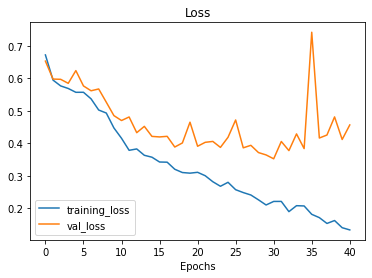

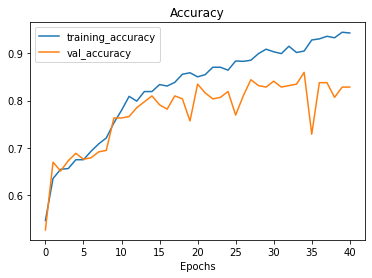

In [798]:
plot_loss_curves(history=history_3)

In [799]:
y_pred = model_3.predict(X_test)

11/11 [==============================] - 0s 18ms/step


In [800]:
y_pred = prediction_function(X_test, y_pred)

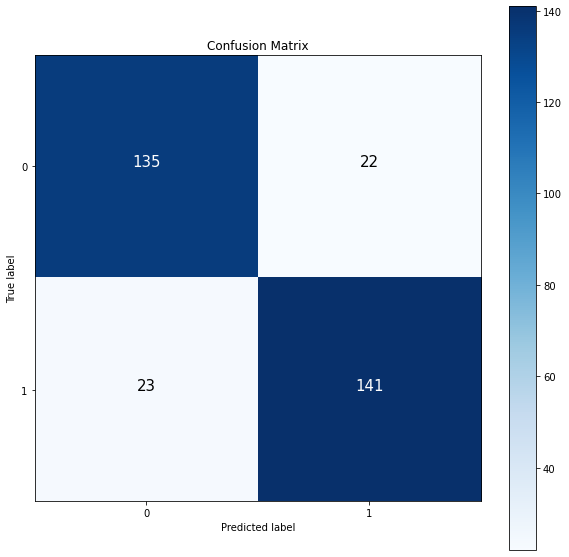

In [801]:
plot_confusion_matrix(y_test, y_pred)

### Scaling the data has a significant impact on the performance of the model in this dataset, as the current model is the best one evaluated so far. It is concluded that normalizing the data by scaling is an important preprocessing step.

# let's scale band2

In [802]:
X = X_band_2/255
y = data['is_iceberg']
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
tf.random.set_seed(42) # random seed for Reproducibility
# Conv2D model 
model_4 = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, (2,2), activation='relu', input_shape=(75, 75,1)),
        tf.keras.layers.MaxPool2D(2,2),
        tf.keras.layers.Conv2D(64,  (2,2), activation='relu'),
        tf.keras.layers.MaxPool2D(2,2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid') # sigmoid activation as the labels are binary
], name = 'model_conv2d_scaled_band2')

early_stopping = tf.keras.callbacks.EarlyStopping(patience = 10) # early stopping callback to stop the model for avoiding overfitting.


model_4.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 1e-3),
              loss='binary_crossentropy', # binary_crossentropy as the labels are binary
              metrics=['accuracy'])


history_4 = model_4.fit(X_train, y_train, epochs=300, verbose= 0,
            validation_data = (X_test,y_test), callbacks=[create_model_checkpoint(model_name=model_4.name),early_stopping])

In [804]:
model_4 = tf.keras.models.load_model("model_experiments/model_conv2d_scaled_band2")
model_4.evaluate(X_test, y_test)
model_4_loss, model_4_accuracy = model_4.evaluate(X_test, y_test)
print(model_4_loss)
print(model_4_accuracy)

11/11 [==============================] - 0s 15ms/step - loss: 0.3920 - accuracy: 0.8224
0.3919697701931
0.822429895401001


In [531]:
band2_scaled_df = pd.DataFrame(history_4.history)

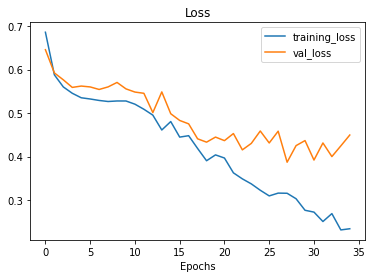

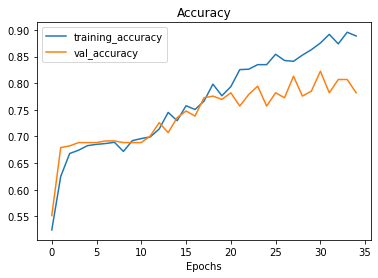

In [532]:
plot_loss_curves(history=history_4)

In [805]:
y_pred = model_4.predict(X_test)

11/11 [==============================] - 0s 23ms/step


In [806]:
y_pred = prediction_function(X_test, y_pred)

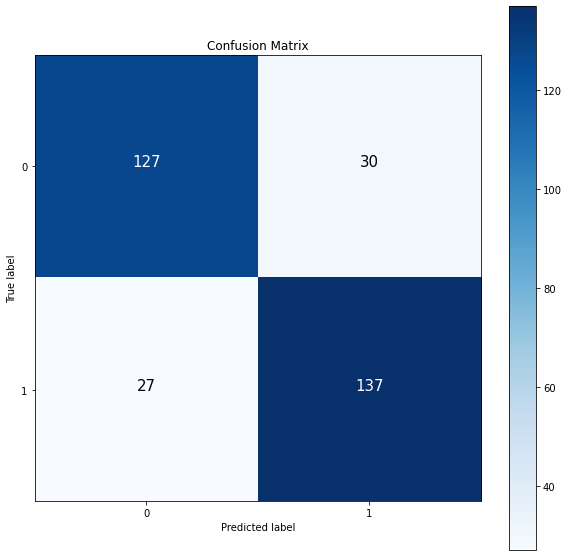

In [807]:
plot_confusion_matrix(y_test, y_pred)

#### A thorough evaluation of the performance of the model using both Band1 and Band2, both in unscaled and scaled forms, has been conducted. The results indicate that the scaling of the data has a positive impact on the performance of the model. Furthermore, it has been observed that the use of Band1 as a feature leads to superior performance as compared to the use of Band2. This suggests that normalizing the data by scaling is an important preprocessing step and that the selection of appropriate features is crucial for achieving optimal performance.

# Section 2
In the upcoming section 2, we will investigate the impact of scaling the signals obtained from the satellite based on the inc_angle variable on the performance of the model. To do this, we will apply various deep learning algorithms on the scaled data and evaluate the results. This is an important step in understanding the impact of this preprocessing technique on the performance of the model and determining the optimal approach for this specific dataset.

In [533]:
data['inc_angle'].value_counts()

na         133
34.4721     23
42.5591     16
36.1061     15
33.6352     15
          ... 
44.0359      1
45.1289      1
43.9369      1
39.6857      1
37.9814      1
Name: inc_angle, Length: 879, dtype: int64

### There are 133 missing values in the inc_angle column, we will replace them with the average value to address this missing data.

In [594]:
data_inc = data.copy()

### Create a list and include all values of inc_angle, excluding the missing values.

In [595]:
ls = []
for i in range(len(data_inc['inc_angle'])):
    if data_inc['inc_angle'][i] != 'na':
        ls.append(data_inc['inc_angle'][i])
    

### Create a dataframe to facilitate a more detailed analysis of the inc_angle variable.

In [536]:
df_angle = pd.DataFrame()
df_angle['inc_angle'] = ls
df_angle


,inc_angle
0,43.9239
1,38.1562
2,45.2859
3,43.8306
4,35.6256
...,...
1466,45.2814
1467,35.7829
1468,34.4721
1469,37.9814


In [537]:
df_angle.describe()

,inc_angle
count,1471.000000
mean,39.268707
std,3.839744
min,24.754600
25%,36.106100
50%,39.501500
75%,42.559100
max,45.937500


### We have determined that the mean of the angles is 39.27, we will replace all missing values with this mean value.

In [ ]:

for i in range(len(data_inc['inc_angle'])):
    if data_inc['inc_angle'][i] == 'na':
        data_inc['inc_angle'][i] = 39.27
    

In [539]:
data_inc['inc_angle'] = data_inc['inc_angle'].astype('float32')

In [540]:
data_inc.describe()

,inc_angle,is_iceberg
count,1604.000000,1604.000000
mean,39.268814,0.469451
std,3.677005,0.499222
min,24.754601,0.000000
25%,36.483175,0.000000
50%,39.270000,0.000000
75%,42.512798,1.000000
max,45.937500,1.000000


### With the implementation of the previous steps, we have successfully obtained the inc_angle for all rows of the dataset.

In [541]:
data_1 = data_inc.copy()

In [542]:
data_1 = data_1.sample(frac=1, random_state=42).reset_index()

### Since we replace missing inc_angle values with the mean and these values are located at the end of the dataset, it is important to shuffle the dataset in order to prevent data leakage.

In [543]:
data_1.drop('index', axis = 1, inplace =True)

In [544]:
data_1

,id,band_1,band_2,inc_angle,is_iceberg
0,f06ecb96,"[-22.622971, -19.042347, -18.257372, -18.69734...","[-23.36264, -22.62306, -23.962086, -24.38596, ...",30.487801,1
1,974931df,"[-27.235119, -26.907366, -24.170664, -24.17072...","[-32.01276, -29.514042, -26.907423, -29.090368...",38.459099,1
2,d6566373,"[-28.63821, -26.238758, -29.042387, -29.042442...","[-25.944237, -25.659485, -28.252216, -31.40442...",39.504799,0
3,6706ea46,"[-22.52327, -20.36145, -18.631905, -19.001574,...","[-26.236002, -27.819691, -25.408276, -25.14897...",36.109100,1
4,b792a605,"[-19.505417, -21.23266, -28.363649, -29.637077...","[-28.36356, -32.289497, -32.289543, -28.767765...",42.412601,0
...,...,...,...,...,...
1599,c7230023,"[-17.143414, -19.606565, -20.195713, -20.19571...","[-27.013645, -31.230762, -25.770786, -25.77078...",40.983799,0
1600,98dc1deb,"[-22.899811, -21.044781, -20.717022, -20.24745...","[-26.116837, -23.543556, -24.238846, -26.42178...",40.712898,1
1601,def4a178,"[-17.564571, -21.82251, -24.996912, -22.757496...","[-30.520924, -27.326965, -26.683331, -26.08412...",38.073601,1
1602,b8cf5edb,"[-28.201336, -24.420252, -21.425047, -21.07051...","[-28.605404, -30.440853, -29.4748, -27.815353,...",44.598400,1


### Let's create new X_bands

In [824]:
X_band_1_shuf = np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in data_1["band_1"]])
X_band_2_shuf = np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in data_1["band_2"]])

In [546]:
import cv2

### The rotation step is a crucial stage in this project. A for loop is used to iterate over all bands, and the OpenCV library is used to rotate each band according to the specified inc_angle for that band. By performing this step, we eliminate the effect of the imaging angle and ensure that all images have the same perspective.

In [825]:
X_band_1_rotated = []
X_band_2_rotated = []
for i in range(len(data_1['inc_angle'])):
    
    img = X_band_1_shuf[i]
    img_2 = X_band_2_shuf[i]

    # Get the inc_angle value
    inc_angle = data_1['inc_angle'][i]

    # Get the image dimensions
    height, width = img.shape[:2]

    # Calculate the rotation matrix
    rotation_matrix = cv2.getRotationMatrix2D((width/2, height/2), -inc_angle, 1)

    # Rotate the image
    rotated_img = cv2.warpAffine(img, rotation_matrix, (width, height))
    rotated_img_2 = cv2.warpAffine(img_2, rotation_matrix, (width, height))

    # Add the rotated image to the list
    X_band_1_rotated.append(rotated_img)
    X_band_2_rotated.append(rotated_img_2)

### Modify the shape and dimensions of the rotated band so that it can be used as input for the Conv2D model.


In [826]:
X_band_1_rotated = np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in X_band_1_rotated])
X_band_2_rotated = np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in X_band_2_rotated])

### Visualize the rotated and original images in each band

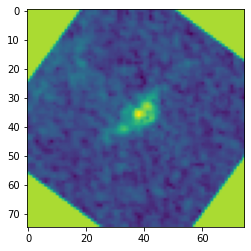

In [549]:
plt.imshow(X_band_1_rotated[10])

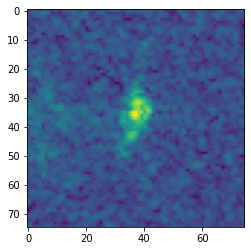

In [550]:
plt.imshow(X_band_1_shuf[10])

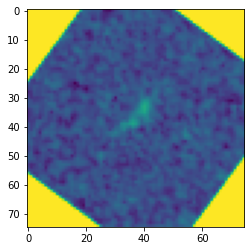

In [551]:
plt.imshow(X_band_2_rotated[10])

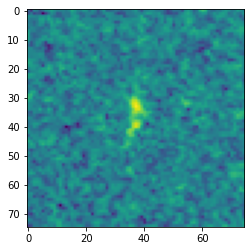

In [552]:
plt.imshow(X_band_2_shuf[10])

### Now that we have rotated the data, we can use it as input for deep learning models and compare the results to see the impact of rotating the data on the model's performance.

### Split the data set.

In [827]:
X = X_band_1_rotated
y = data_1['is_iceberg']
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Schedule the learning rate

In [380]:
tf.random.set_seed(42) # random seed for Reproducibility
# Conv2D model 
model_5 = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, (2,2), activation='relu', input_shape=(75, 75,1)),
        tf.keras.layers.MaxPool2D(2,2),
        tf.keras.layers.Conv2D(64,  (2,2), activation='relu'),
        tf.keras.layers.MaxPool2D(2,2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid') # sigmoid activation as the labels are binary
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-5 * 10**(epoch/20)) # learning rate scheduler callback

model_5.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 1e-5),
              loss='binary_crossentropy', # binary_crossentropy as the labels are binary
              metrics=['accuracy'])


history_5 = model_5.fit(X_train, y_train, epochs=100, verbose= 0,
            validation_data = (X_test,y_test), callbacks=[lr_schedule])


In [385]:
df_inc_lr = pd.DataFrame(history_5.history)

In [386]:
df_inc_lr.describe()

,loss,accuracy,val_loss,val_accuracy,lr
count,100.000000,100.000000,100.000000,100.000000,100.000000
mean,0.574906,0.670779,0.689237,0.624112,0.081954
std,0.187280,0.138146,0.354536,0.086266,0.179519
min,0.226761,0.468433,0.457242,0.461059,0.000010
25%,0.428302,0.526111,0.569783,0.538941,0.000173
50%,0.612545,0.678098,0.654457,0.635514,0.002990
75%,0.696088,0.790530,0.691115,0.697040,0.051648
max,1.278661,0.916602,3.771929,0.791277,0.891251


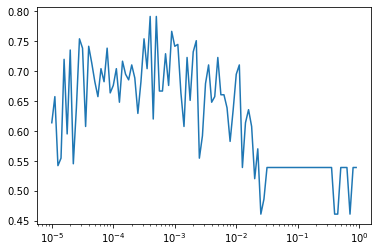

In [390]:
plt.semilogx(history_5.history['lr'], history_5.history['val_accuracy'])

In [ ]:
tf.random.set_seed(42) # random seed for Reproducibility
# Conv2D model 
model_5 = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, (2,2), activation='relu', input_shape=(75, 75,1)),
        tf.keras.layers.MaxPool2D(2,2),
        tf.keras.layers.Conv2D(64,  (2,2), activation='relu'),
        tf.keras.layers.MaxPool2D(2,2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid') # sigmoid activation as the labels are binary
], name = 'model_conv2d_band1_rotated')

early_stopping = tf.keras.callbacks.EarlyStopping(patience = 10) # early stopping callback to stop the model for avoiding overfitting.


model_5.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 1e-3),
              loss='binary_crossentropy', # binary_crossentropy as the labels are binary
              metrics=['accuracy'])


history_5 = model_5.fit(X_train, y_train, epochs=300, verbose= 0,
            validation_data = (X_test,y_test), callbacks=[create_model_checkpoint(model_name=model_5.name),early_stopping])


In [830]:
model_5 = tf.keras.models.load_model("model_experiments/model_conv2d_band1_rotated")
model_5.evaluate(X_test, y_test)
model_5_loss, model_5_accuracy = model_5.evaluate(X_test, y_test)
print(model_5_loss)
print(model_5_accuracy)

11/11 [==============================] - 0s 20ms/step - loss: 0.4559 - accuracy: 0.8505
0.4558805525302887
0.8504672646522522


In [831]:
band_1_df = pd.DataFrame(history_5.history)

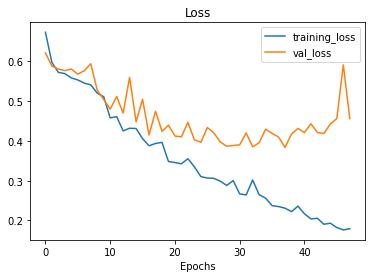

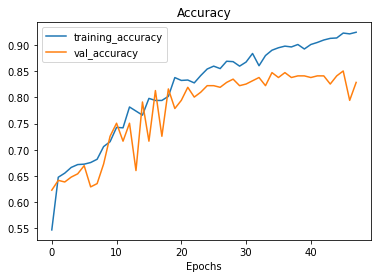

In [832]:
plot_loss_curves(history=history_5)


11/11 [==============================] - 0s 22ms/step


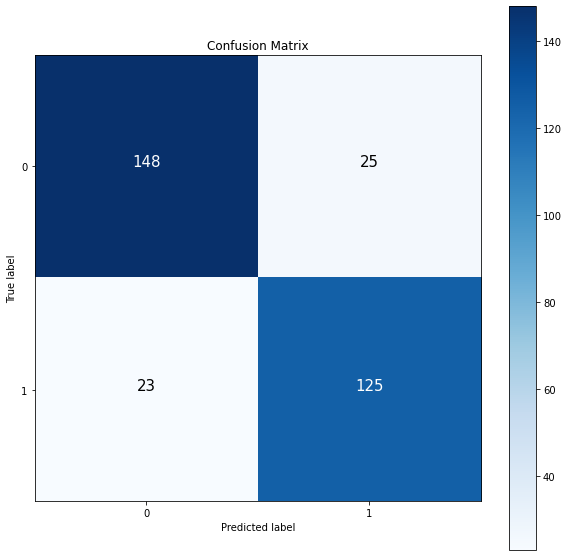

In [833]:
y_pred = model_5.predict(X_test)
y_pred = prediction_function(X_test, y_pred)# it looks binary
plot_confusion_matrix(y_test, y_pred)

## In order to improve the performance of the model, we will scale the dataset and apply a deeper convolutional network. 

### This is an important step as it allows us to investigate the impact of scaling on the performance of the model and determine the optimal approach for this specific dataset. By using a deeper convolutional network, we can increase the complexity of the model, allowing for more accurate predictions.

In [834]:
X = X_band_1_rotated/255
y = data_1['is_iceberg']
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
tf.random.set_seed(42) # random seed for Reproducibility
# Conv2D model 
model_6 = tf.keras.Sequential([
        tf.keras.layers.Conv2D(256, (2,2), activation='relu', input_shape=(75, 75,1)),
        tf.keras.layers.MaxPool2D(2,2),
        tf.keras.layers.Conv2D(128,  (2,2), activation='relu'),
        tf.keras.layers.MaxPool2D(2,2),
        tf.keras.layers.Conv2D(64,  (2,2), activation='relu'),
        tf.keras.layers.MaxPool2D(2,2),
        tf.keras.layers.Conv2D(32,  (2,2), activation='relu'),
        tf.keras.layers.MaxPool2D(2,2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(1024, activation='relu'),
        tf.keras.layers.Dense(2048, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid') # sigmoid activation as the labels are binary
], name = 'model_conv2d_band1_rotated_scaled')

early_stopping = tf.keras.callbacks.EarlyStopping(patience = 10) # early stopping callback to stop the model for avoiding overfitting.


model_6.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 1e-3),
              loss='binary_crossentropy', # binary_crossentropy as the labels are binary
              metrics=['accuracy'])


history_6 = model_6.fit(X_train, y_train, epochs=300, verbose= 0,
            validation_data = (X_test,y_test), callbacks=[create_model_checkpoint(model_name=model_6.name),early_stopping])

In [839]:
model_6 = tf.keras.models.load_model("model_experiments/model_conv2d_band1_rotated_scaled")
model_6.evaluate(X_test, y_test)
model_6_loss, model_6_accuracy = model_6.evaluate(X_test, y_test)
print(model_6_loss)
print(model_6_accuracy)

11/11 [==============================] - 1s 125ms/step - loss: 0.4370 - accuracy: 0.8598
0.4370175302028656
0.8598130941390991


In [840]:
band_1_df_scaled = pd.DataFrame(history_6.history)

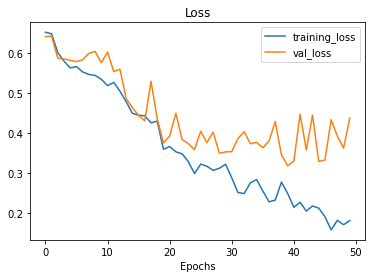

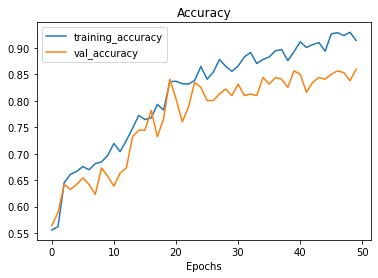

In [841]:
plot_loss_curves(history=history_6)


11/11 [==============================] - 1s 125ms/step


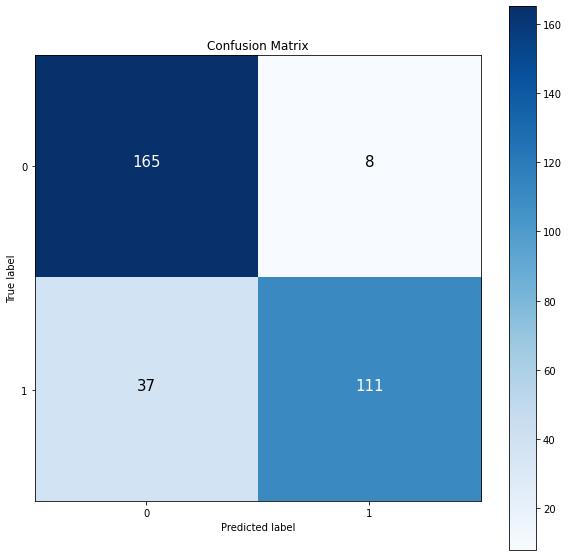

In [842]:
y_pred = model_6.predict(X_test)
y_pred = prediction_function(X_test, y_pred)# it looks binary
plot_confusion_matrix(y_test, y_pred)

### So far, model_6, which is scaled_rotated data set and deeper newtork, has the highest accuracy, 86%. 

## Let's try the same deep model on the scaled dataset without removing the impact of inc_angle.

In [843]:
X = X_band_1/255
y = data['is_iceberg']
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
tf.random.set_seed(42) # random seed for Reproducibility
# Conv2D model 
model_7 = tf.keras.Sequential([
        tf.keras.layers.Conv2D(256, (2,2), activation='relu', input_shape=(75, 75,1)),
        tf.keras.layers.MaxPool2D(2,2),
        tf.keras.layers.Conv2D(128,  (2,2), activation='relu'),
        tf.keras.layers.MaxPool2D(2,2),
        tf.keras.layers.Conv2D(64,  (2,2), activation='relu'),
        tf.keras.layers.MaxPool2D(2,2),
        tf.keras.layers.Conv2D(32,  (2,2), activation='relu'),
        tf.keras.layers.MaxPool2D(2,2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(1024, activation='relu'),
        tf.keras.layers.Dense(2048, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid') # sigmoid activation as the labels are binary
], name = 'model_conv2d_band1_scaled_deep')

early_stopping = tf.keras.callbacks.EarlyStopping(patience = 10) # early stopping callback to stop the model for avoiding overfitting.


model_7.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 1e-3),
              loss='binary_crossentropy', # binary_crossentropy as the labels are binary
              metrics=['accuracy'])


history_7 = model_7.fit(X_train, y_train, epochs=300, verbose= 0,
            validation_data = (X_test,y_test), callbacks=[create_model_checkpoint(model_name=model_7.name),early_stopping])

In [848]:
model_7 = tf.keras.models.load_model("model_experiments/model_conv2d_band1_scaled_deep")
model_7.evaluate(X_test, y_test)
model_7_loss, model_7_accuracy = model_7.evaluate(X_test, y_test)
print(model_7_loss)
print(model_7_accuracy)

11/11 [==============================] - 1s 116ms/step - loss: 0.4199 - accuracy: 0.8380
0.41986554861068726
0.8380062580108643


In [849]:
band_1_df_scaled = pd.DataFrame(history_7.history)


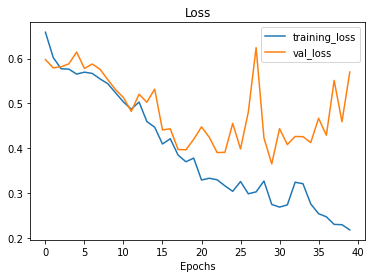

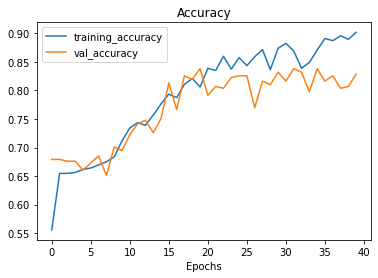

In [850]:
plot_loss_curves(history=history_7)

11/11 [==============================] - 1s 112ms/step


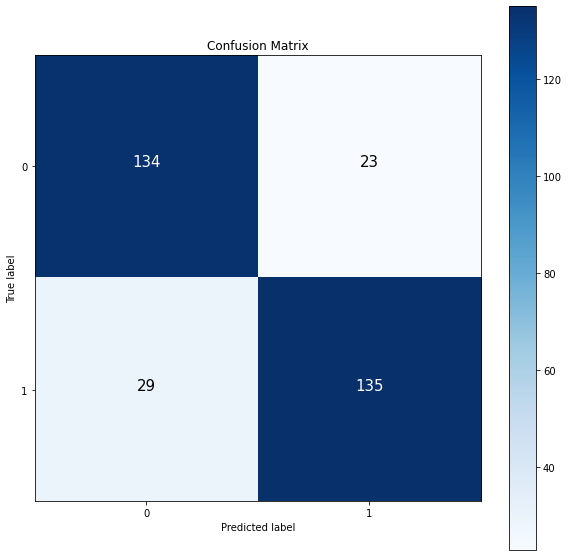

In [851]:
y_pred = model_7.predict(X_test)
y_pred = prediction_function(X_test, y_pred)# it looks binary
plot_confusion_matrix(y_test, y_pred)

# let's compare all models

In [852]:
results = pd.DataFrame({"Band1": model_accuracy,
                                  "Band2": model_2_accuracy,
                                  "Band1_scaled": model_3_accuracy,
                                  "Band2_scaled": model_4_accuracy,
                                  "Band1_rotated": model_5_accuracy,
                                  "Band1_rotated_scaled_deep": model_6_accuracy,
                                  "Band_1_scaled_deep": model_7_accuracy,
                                 }, index=['Accuracy'])
results = results.transpose()
results

,Accuracy
Band1,0.800623
Band2,0.766355
Band1_scaled,0.859813
Band2_scaled,0.822430
Band1_rotated,0.850467
Band1_rotated_scaled_deep,0.859813
Band_1_scaled_deep,0.838006


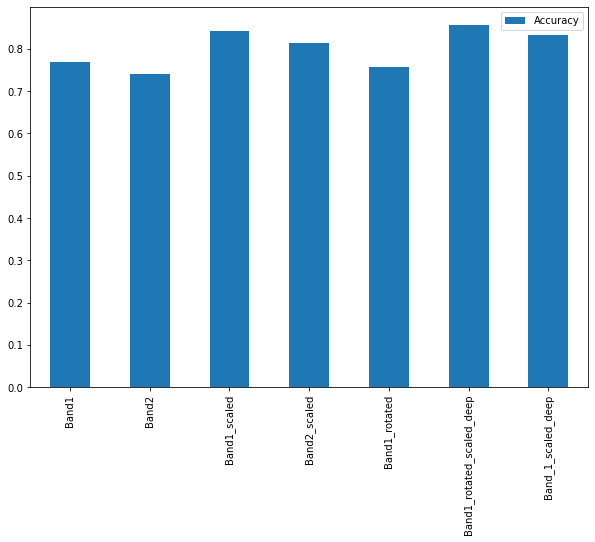

In [593]:
results.plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0));

# conclousion

### After evaluating various models, it has been determined that model_6, which is based on a scaled_rotated dataset and a deeper neural network, has the highest accuracy of 86%. This suggests that the application of a deeper neural network, rotating the images based on the inc_angle, and the scaling of the dataset have a positive impact on the performance of the model and that model_6 is the most effective model evaluated thus far.

# Section 3
In this section, we drop the rows belonging to the na value of inc_angle. Then, compare the results with the last section to see if the droping data is more efficient or filling the data.

In [853]:
data_drop = data.copy()

In [854]:
data_drop.head()

,id,band_1,band_2,inc_angle,is_iceberg
0,dfd5f913,"[-27.878360999999998, -27.15416, -28.668615, -...","[-27.154118, -29.537888, -31.0306, -32.190483,...",43.9239,0
1,e25388fd,"[-12.242375, -14.920304999999999, -14.920363, ...","[-31.506321, -27.984554, -26.645678, -23.76760...",38.1562,0
2,58b2aaa0,"[-24.603676, -24.603714, -24.871029, -23.15277...","[-24.870956, -24.092632, -20.653963, -19.41104...",45.2859,1
3,4cfc3a18,"[-22.454607, -23.082819, -23.998013, -23.99805...","[-27.889421, -27.519794, -27.165262, -29.10350...",43.8306,0
4,271f93f4,"[-26.006956, -23.164886, -23.164886, -26.89116...","[-27.206915, -30.259186, -30.259186, -23.16495...",35.6256,0


In [855]:
data_drop.inc_angle.value_counts()

na         133
34.4721     23
42.5591     16
36.1061     15
33.6352     15
          ... 
44.0359      1
45.1289      1
43.9369      1
39.6857      1
37.9814      1
Name: inc_angle, Length: 879, dtype: int64

### Let's drop na values

In [856]:
data_drop = data_drop.drop(data_drop[(data_drop['inc_angle'] =='na')].index)

In [857]:
# check if the missing value has dropped
data_drop['inc_angle'].value_counts()

34.4721    23
42.5591    16
33.6352    15
36.1061    15
39.2340    13
           ..
44.0359     1
45.1289     1
43.9369     1
39.6857     1
37.9814     1
Name: inc_angle, Length: 878, dtype: int64

### Let's shuffle the data and reset the indexes to avoid any problems with index of dropped data.

In [858]:
data_drop_shuf = data_drop.sample(frac=1, random_state=42).reset_index()

In [859]:
data_drop_shuf.drop('index', axis=1, inplace=True)

In [860]:
data_drop_shuf.head(10)

,id,band_1,band_2,inc_angle,is_iceberg
0,292af507,"[-25.56883, -22.726696, -27.096649, -21.592245...","[-30.787086, -28.951679, -25.568882, -27.43736...",39.9795,1
1,c84a92a0,"[-10.898708, -17.427465, -16.254622, -14.67106...","[-28.204737, -25.706028, -24.213421, -23.55348...",35.7707,0
2,1df59f54,"[-19.764078, -18.38652, -17.506254, -17.935343...","[-29.443293, -26.345322, -26.944654, -26.34546...",35.7448,0
3,9f84a328,"[-20.503941, -21.734337, -23.168242, -21.92532...","[-24.108097, -26.690027, -25.741575, -24.61929...",45.1398,0
4,a68bcde2,"[-21.451096, -19.784416, -20.502731, -21.61995...","[-26.228737, -23.949936, -23.950001, -26.22893...",36.5207,0
5,058a5768,"[-28.628902, -27.177944, -25.650232, -27.51872...","[-25.650122, -25.934986, -27.518665, -28.24296...",39.5048,0
6,9c810836,"[-21.891558, -20.868565, -20.247934, -20.86867...","[-33.237514, -30.410988, -26.268532, -26.26858...",38.8723,1
7,18ec6625,"[-17.447321, -14.643818, -10.496216, -11.12213...","[-26.684948, -29.488592, -25.562771, -24.80707...",34.9528,0
8,0615d2f8,"[-20.971563, -20.475136, -23.997002, -24.49351...","[-28.274515, -28.678625, -34.2952, -31.040695,...",43.9409,1
9,2336fe9c,"[-20.833214, -21.799376, -23.485867, -25.84792...","[-30.845261, -23.90958, -27.323578, -26.123688...",34.4721,1


### Let's define the X_band1 and X_band2

In [861]:
X_band_1_drop = np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in data_drop_shuf["band_1"]])
X_band_2_drop = np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in data_drop_shuf["band_2"]])

### As we already know the best performance is on the sacled data and band1. Let's do it!

In [862]:
X = X_band_1_drop/255
y = data_drop_shuf['is_iceberg']
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
tf.random.set_seed(42) # random seed for Reproducibility
# Conv2D model 
model_8 = tf.keras.Sequential([
        tf.keras.layers.Conv2D(256, (2,2), activation='relu', input_shape=(75, 75,1)),
        tf.keras.layers.MaxPool2D(2,2),
        tf.keras.layers.Conv2D(128,  (2,2), activation='relu'),
        tf.keras.layers.MaxPool2D(2,2),
        tf.keras.layers.Conv2D(64,  (2,2), activation='relu'),
        tf.keras.layers.MaxPool2D(2,2),
        tf.keras.layers.Conv2D(32,  (2,2), activation='relu'),
        tf.keras.layers.MaxPool2D(2,2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(1024, activation='relu'),
        tf.keras.layers.Dense(2048, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid') # sigmoid activation as the labels are binary
], name = 'model_conv2d_band1_scaled_deep_drop')

early_stopping = tf.keras.callbacks.EarlyStopping(patience = 10) # early stopping callback to stop the model for avoiding overfitting.


model_8.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 1e-3),
              loss='binary_crossentropy', # binary_crossentropy as the labels are binary
              metrics=['accuracy'])


history_8 = model_8.fit(X_train, y_train, epochs=300, verbose= 0,
            validation_data = (X_test,y_test), callbacks=[create_model_checkpoint(model_name=model_8.name),early_stopping])

In [867]:
model_8 = tf.keras.models.load_model("model_experiments/model_conv2d_band1_scaled_deep_drop")
model_8.evaluate(X_test, y_test)
model_8_loss, model_8_accuracy = model_8.evaluate(X_test, y_test)
print(model_8_loss)
print(model_8_accuracy)

10/10 [==============================] - 1s 119ms/step - loss: 0.3273 - accuracy: 0.8712
0.32725852727890015
0.8711864352226257


In [865]:
band_1_df_scaled = pd.DataFrame(history_8.history)

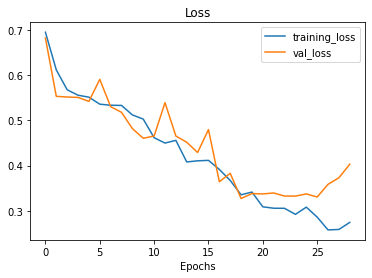

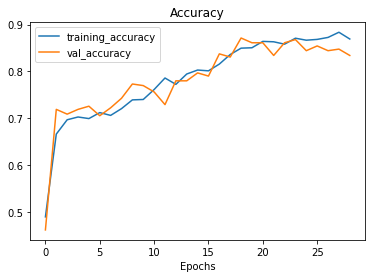

In [866]:
plot_loss_curves(history=history_8)

10/10 [==============================] - 1s 114ms/step


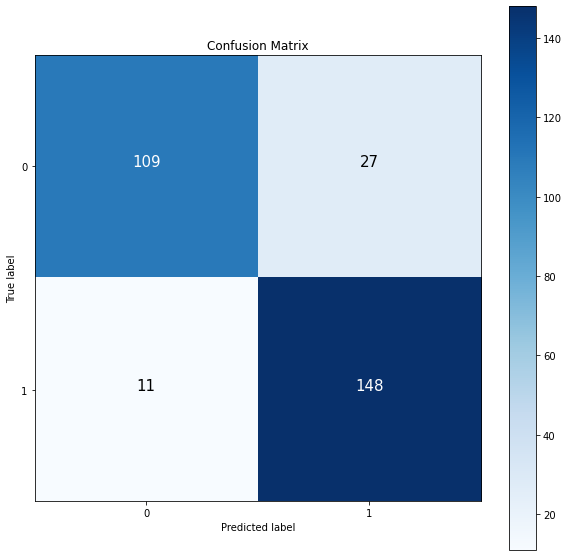

In [868]:
y_pred = model_8.predict(X_test)
y_pred = prediction_function(X_test, y_pred)# it looks binary
plot_confusion_matrix(y_test, y_pred)

### For the next model, let's apply the rotation based on the inc_angle on the dropped dataset and see if there is any imporvment in the results.

In [869]:
# change the type of inc_angle
data_drop_shuf['inc_angle'] = data_drop_shuf['inc_angle'].astype('float32')

In [870]:
data_drop_shuf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1471 entries, 0 to 1470
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   id          1471 non-null   object 
 1   band_1      1471 non-null   object 
 2   band_2      1471 non-null   object 
 3   inc_angle   1471 non-null   float32
 4   is_iceberg  1471 non-null   int64  
dtypes: float32(1), int64(1), object(3)
memory usage: 51.8+ KB


In [924]:
X_band_1_drop_rotated = []

for i in range(len(data_drop_shuf['inc_angle'])):
    
    img = X_band_1_drop[i]

    # Get the inc_angle value
    inc_angle = data_drop_shuf['inc_angle'][i]

    # Get the image dimensions
    height, width = img.shape[:2]

    # Calculate the rotation matrix
    rotation_matrix = cv2.getRotationMatrix2D((width/2, height/2), -inc_angle, 1)

    # Rotate the image
    rotated_img = cv2.warpAffine(img, rotation_matrix, (width, height))

    # Add the rotated image to the list
    X_band_1_drop_rotated.append(rotated_img)

In [925]:
X_band_1_drop_rotated = np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in X_band_1_drop_rotated])

In [926]:
X = X_band_1_drop_rotated/255
y = data_drop_shuf['is_iceberg']
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
tf.random.set_seed(42) # random seed for Reproducibility
# Conv2D model 
model_9_1 = tf.keras.Sequential([
        tf.keras.layers.Conv2D(256, (2,2), activation='relu', input_shape=(75, 75,1)),
        tf.keras.layers.Conv2D(256,  (2,2), activation='relu'),
        tf.keras.layers.MaxPool2D(2,2),
        tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Conv2D(128,  (2,2), activation='relu'),
        tf.keras.layers.Conv2D(128,  (2,2), activation='relu'),
        tf.keras.layers.MaxPool2D(2,2),
        tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Conv2D(64,  (2,2), activation='relu'),
        tf.keras.layers.Conv2D(64,  (2,2), activation='relu'),
        tf.keras.layers.MaxPool2D(2,2),
        tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Conv2D(32,  (2,2), activation='relu'),
        tf.keras.layers.Conv2D(32,  (2,2), activation='relu'),
        tf.keras.layers.MaxPool2D(2,2),
        tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Dense(512, activation='relu'),
        # tf.keras.layers.Dense(1024, activation='relu'),
        # tf.keras.layers.Dense(2048, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid') # sigmoid activation as the labels are binary
], name = 'model_conv2d_band_Deeper')

early_stopping = tf.keras.callbacks.EarlyStopping(patience = 10) # early stopping callback to stop the model for avoiding overfitting.


model_9_1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 1e-3),
              loss='binary_crossentropy', # binary_crossentropy as the labels are binary
              metrics=['accuracy'])


model_9_1 = model_9_1.fit(X_train, y_train, epochs=300, verbose= 0,
            validation_data = (X_test,y_test), callbacks=[create_model_checkpoint(model_name=model_9_1.name),early_stopping])

In [930]:
model_9_1 = tf.keras.models.load_model("model_experiments/model_conv2d_band_Deeper")
model_9_1.evaluate(X_test, y_test)
model_9_1_loss, model_9_1_accuracy = model_9_1.evaluate(X_test, y_test)
print(model_9_1_loss)
print(model_9_1_accuracy)

10/10 [==============================] - 4s 355ms/step - loss: 0.3068 - accuracy: 0.8746
0.30680927634239197
0.8745762705802917


In [875]:
model_9 = tf.keras.models.load_model("model_experiments/model_conv2d_band1_scaled_rotated_deep_drop")
model_9.evaluate(X_test, y_test)
model_9_loss, model_9_accuracy = model_9.evaluate(X_test, y_test)
print(model_9_loss)
print(model_9_accuracy)

10/10 [==============================] - 1s 111ms/step - loss: 0.3135 - accuracy: 0.8746
0.31351834535598755
0.8745762705802917


In [876]:
band_1_df_scaled = pd.DataFrame(history_9.history)

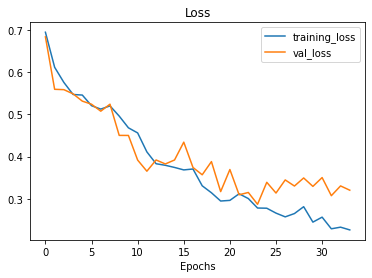

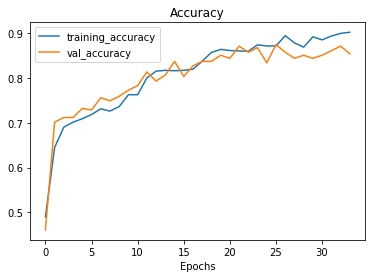

In [877]:
plot_loss_curves(history=history_9)

10/10 [==============================] - 1s 112ms/step


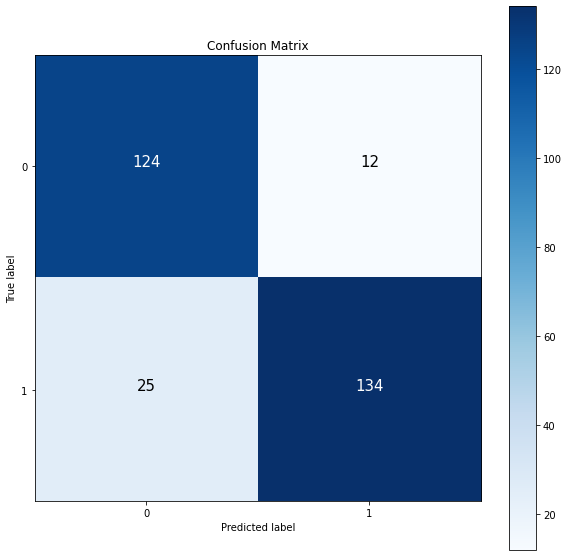

In [878]:
y_pred = model_9.predict(X_test)
y_pred = prediction_function(X_test, y_pred)# it looks binary
plot_confusion_matrix(y_test, y_pred)

### model 8 and 9 have the best performance so far. Let's use model 8 and apply data augmentation to see the results.

# Section 4: Data Augmentation

In [879]:
X = X_band_1_drop/255
y = data_drop_shuf['is_iceberg']
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [880]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

In [881]:
data_augmentation = keras.Sequential([
  preprocessing.RandomFlip("horizontal"),
  preprocessing.RandomRotation(0.2),
  preprocessing.RandomZoom(0.2),
  preprocessing.RandomHeight(0.2),
  preprocessing.RandomWidth(0.2)
], name ="data_augmentation")

In [ ]:
tf.random.set_seed(42) # random seed for Reproducibility
# Conv2D model 
model_10 = tf.keras.Sequential([
        tf.keras.layers.Conv2D(256, (2,2), activation='relu', input_shape=(75, 75,1)),
        tf.keras.layers.MaxPool2D(2,2),
        tf.keras.layers.Conv2D(128,  (2,2), activation='relu'),
        tf.keras.layers.MaxPool2D(2,2),
        tf.keras.layers.Conv2D(64,  (2,2), activation='relu'),
        tf.keras.layers.MaxPool2D(2,2),
        tf.keras.layers.Conv2D(32,  (2,2), activation='relu'),
        tf.keras.layers.MaxPool2D(2,2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(1024, activation='relu'),
        tf.keras.layers.Dense(2048, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid') # sigmoid activation as the labels are binary
], name = 'data_augmented_model')

early_stopping = tf.keras.callbacks.EarlyStopping(patience = 10) # early stopping callback to stop the model for avoiding overfitting.


model_10.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 1e-3),
              loss='binary_crossentropy', # binary_crossentropy as the labels are binary
              metrics=['accuracy'])


history_10 = model_10.fit(data_augmentation(X_train), y_train, epochs=300, verbose= 0,
            validation_data = (X_test,y_test), callbacks=[create_model_checkpoint(model_name=model_10.name),early_stopping])

In [887]:
model_10 = tf.keras.models.load_model("model_experiments/data_augmented_model")
model_10.evaluate(X_test, y_test)
model_10_loss, model_10_accuracy = model_10.evaluate(X_test, y_test)
print(model_10_loss)
print(model_10_accuracy)

10/10 [==============================] - 1s 115ms/step - loss: 0.3273 - accuracy: 0.8712
0.32725852727890015
0.8711864352226257


In [888]:
band_1_df_scaled = pd.DataFrame(history_10.history)

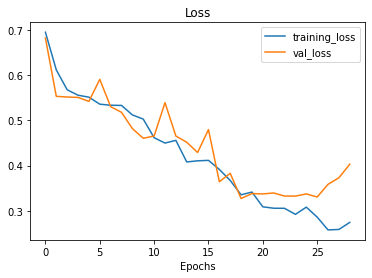

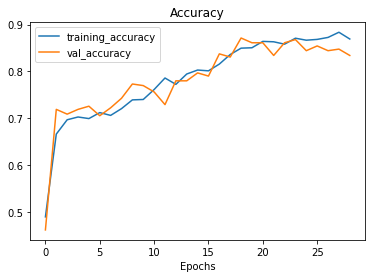

In [889]:
plot_loss_curves(history=history_10)

10/10 [==============================] - 1s 124ms/step


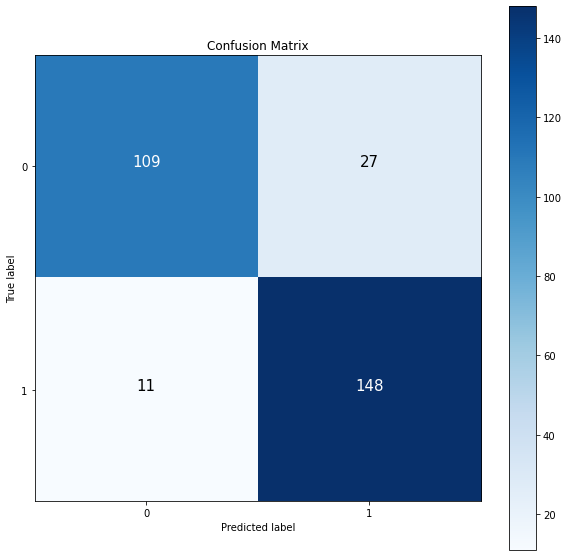

In [890]:
y_pred = model_10.predict(X_test)
y_pred = prediction_function(X_test, y_pred)# it looks binary
plot_confusion_matrix(y_test, y_pred)

### the result for data augmentation is the same as before, then we do not need to add data augmentation layer.

# Section 6:
### Machine Larning With Random Forest Classifier and Support Vector Classifer

In [714]:
X = X_band_1_drop
y = data_drop_shuf['is_iceberg']
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [716]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
X_test_sklearn = np.array(X_test).reshape(len(X_test), -1)
X_train_sklearn = np.array(X_train).reshape(len(X_train), -1)

#Using the Support Vector Classifer to build model
svc_model = SVC(kernel="poly", gamma="auto")
svc_model.fit(X_train_sklearn, y_train) #Training the model
y_predict = svc_model.predict(X_test_sklearn) #Testing the model
print("SVC accuracy without scaling {:.2f}%".format(accuracy_score(y_test, y_predict)*100))

#Using the Random Forest Classifier to build model
rfc_model = RandomForestClassifier() #default hyperparameters used
rfc_model.fit(X_train_sklearn, y_train) #Training the model
y_predict = rfc_model.predict(X_test_sklearn) #Testing the model
print("RFC accuracy without scaling {:.2f}%".format(accuracy_score(y_test, y_predict)*100))

SVC accuracy without scaling 69.83%
RFC accuracy without scaling 70.51%


In [717]:
X = X_band_1_drop/255
y = data_drop_shuf['is_iceberg']
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [719]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
X_test_sklearn = np.array(X_test).reshape(len(X_test), -1)
X_train_sklearn = np.array(X_train).reshape(len(X_train), -1)

#Using the Support Vector Classifer to build model
svc_model = SVC(kernel="poly", gamma="auto")
svc_model.fit(X_train_sklearn, y_train) #Training the model
y_predict = svc_model.predict(X_test_sklearn) #Testing the model
print("SVC accuracy with scaling {:.2f}%".format(accuracy_score(y_test, y_predict)*100))

#Using the Random Forest Classifier to build model
rfc_model = RandomForestClassifier() #default hyperparameters used
rfc_model.fit(X_train_sklearn, y_train) #Training the model
y_predict = rfc_model.predict(X_test_sklearn) #Testing the model
print("RFC accuracy with scaling {:.2f}%".format(accuracy_score(y_test, y_predict)*100))

SVC accuracy with scaling 53.90%
RFC accuracy with scaling 69.83%


### As we can see, the results for machine learning is not as good as deep learning.

# Section 7:
### Let's Combine Band_1 and Band_2 together to make a feature that includes both bands, and then apply deep learning models.

In [912]:
train_data = np.concatenate([X_band_1_drop[:, :, :, np.newaxis]
                          , X_band_2_drop[:, :, :, np.newaxis]
                         , ((X_band_1_drop+X_band_2_drop)/2)[:, :, :, np.newaxis]], axis=-1)

In [913]:
train_data.shape

(1471, 75, 75, 3)

In [919]:
X = train_data/255
y = data_drop_shuf['is_iceberg']
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
tf.random.set_seed(42) # random seed for Reproducibility
# Conv2D model 
model_11 = tf.keras.Sequential([
        tf.keras.layers.Conv2D(256, (2,2), activation='relu', input_shape=(75, 75,3)),
        tf.keras.layers.Conv2D(256,  (2,2), activation='relu'),
        tf.keras.layers.MaxPool2D(2,2),
        tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Conv2D(128,  (2,2), activation='relu'),
        tf.keras.layers.Conv2D(128,  (2,2), activation='relu'),
        tf.keras.layers.MaxPool2D(2,2),
        tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Conv2D(64,  (2,2), activation='relu'),
        tf.keras.layers.Conv2D(64,  (2,2), activation='relu'),
        tf.keras.layers.MaxPool2D(2,2),
        tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Conv2D(32,  (2,2), activation='relu'),
        tf.keras.layers.Conv2D(32,  (2,2), activation='relu'),
        tf.keras.layers.MaxPool2D(2,2),
        tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Dense(512, activation='relu'),
        # tf.keras.layers.Dense(1024, activation='relu'),
        # tf.keras.layers.Dense(2048, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid') # sigmoid activation as the labels are binary
], name = 'model_conv2d_band_combined')

early_stopping = tf.keras.callbacks.EarlyStopping(patience = 10) # early stopping callback to stop the model for avoiding overfitting.


model_11.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 1e-3),
              loss='binary_crossentropy', # binary_crossentropy as the labels are binary
              metrics=['accuracy'])


history_11 = model_11.fit(X_train, y_train, epochs=300, verbose= 0,
            validation_data = (X_test,y_test), callbacks=[create_model_checkpoint(model_name=model_11.name),early_stopping])

In [921]:
model_11 = tf.keras.models.load_model("model_experiments/model_conv2d_band_combined")
model_11.evaluate(X_test, y_test)
model_11_loss, model_11_accuracy = model_11.evaluate(X_test, y_test)
print(model_11_loss)
print(model_11_accuracy)



10/10 [==============================] - 4s 379ms/step - loss: 0.2868 - accuracy: 0.9051
0.28678083419799805
0.9050847291946411


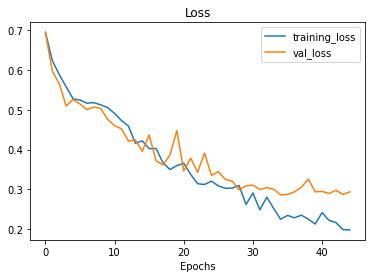

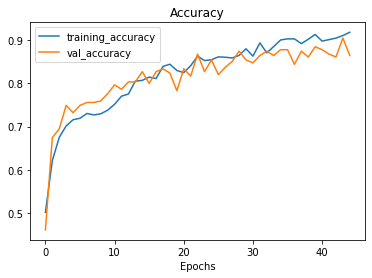

In [922]:
band_1_df_scaled = pd.DataFrame(history_11.history)
plot_loss_curves(history=history_11)


10/10 [==============================] - 4s 388ms/step


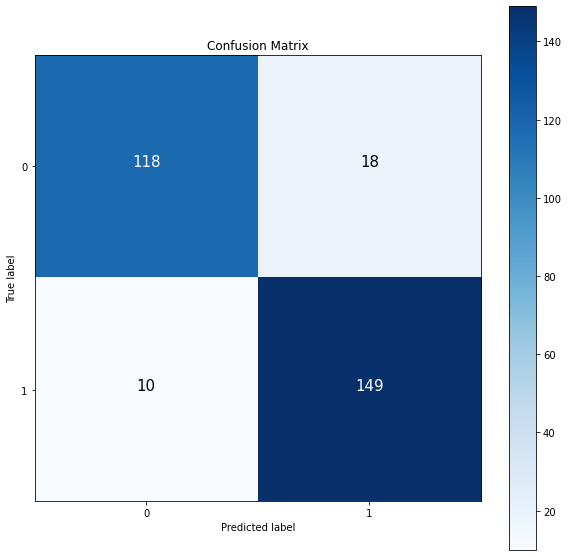

In [923]:
y_pred = model_11.predict(X_test)
y_pred = prediction_function(X_test, y_pred)# it looks binary
plot_confusion_matrix(y_test, y_pred)

# Conclusion

In conclusion, the first finding shows that Deep Learning models perform significantly better than Machine Learning models. Additionally, the combination of both bands resulted in a decrease in the loss function and an increase in accuracy, as reflected in the improved confusion matrix.